# Visualize Excess Deaths by age band for CDCs state data
CDC does not provide an estimate for 'Expected Deaths' by age groups, so we used the method of Kobak and Karlinsky to calculate it. See `2_calculate_baselines.ipynb`.


In [2]:
library(tidyverse)
library(geofacet)
library(ggtext)

theme_set(theme_minimal())

options(repr.plot.width = 8, repr.plot.height = 4.5, repr.plot.res = 240)

df <- read_rds("data/us_excess_deaths_per_age_group.rds")

head(df)

,Jurisdiction,Age Group,Year,Week,Number of Deaths,Type,Date,Population,Population_all_ages,Population_age_group_nation
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>
1,Alabama,<65,2018,37,285.3385,Predicted,2018-09-16,4033195,4907439,272637837
2,Alabama,<65,2018,38,288.3385,Predicted,2018-09-23,4033195,4907439,272637837
3,Alabama,<65,2018,35,288.1385,Predicted,2018-09-02,4033195,4907439,272637837
4,Alabama,<65,2018,36,288.1385,Predicted,2018-09-09,4033195,4907439,272637837
5,Alabama,<65,2018,50,311.9385,Predicted,2018-12-16,4033195,4907439,272637837
6,Alabama,<65,2018,51,320.3385,Predicted,2018-12-23,4033195,4907439,272637837


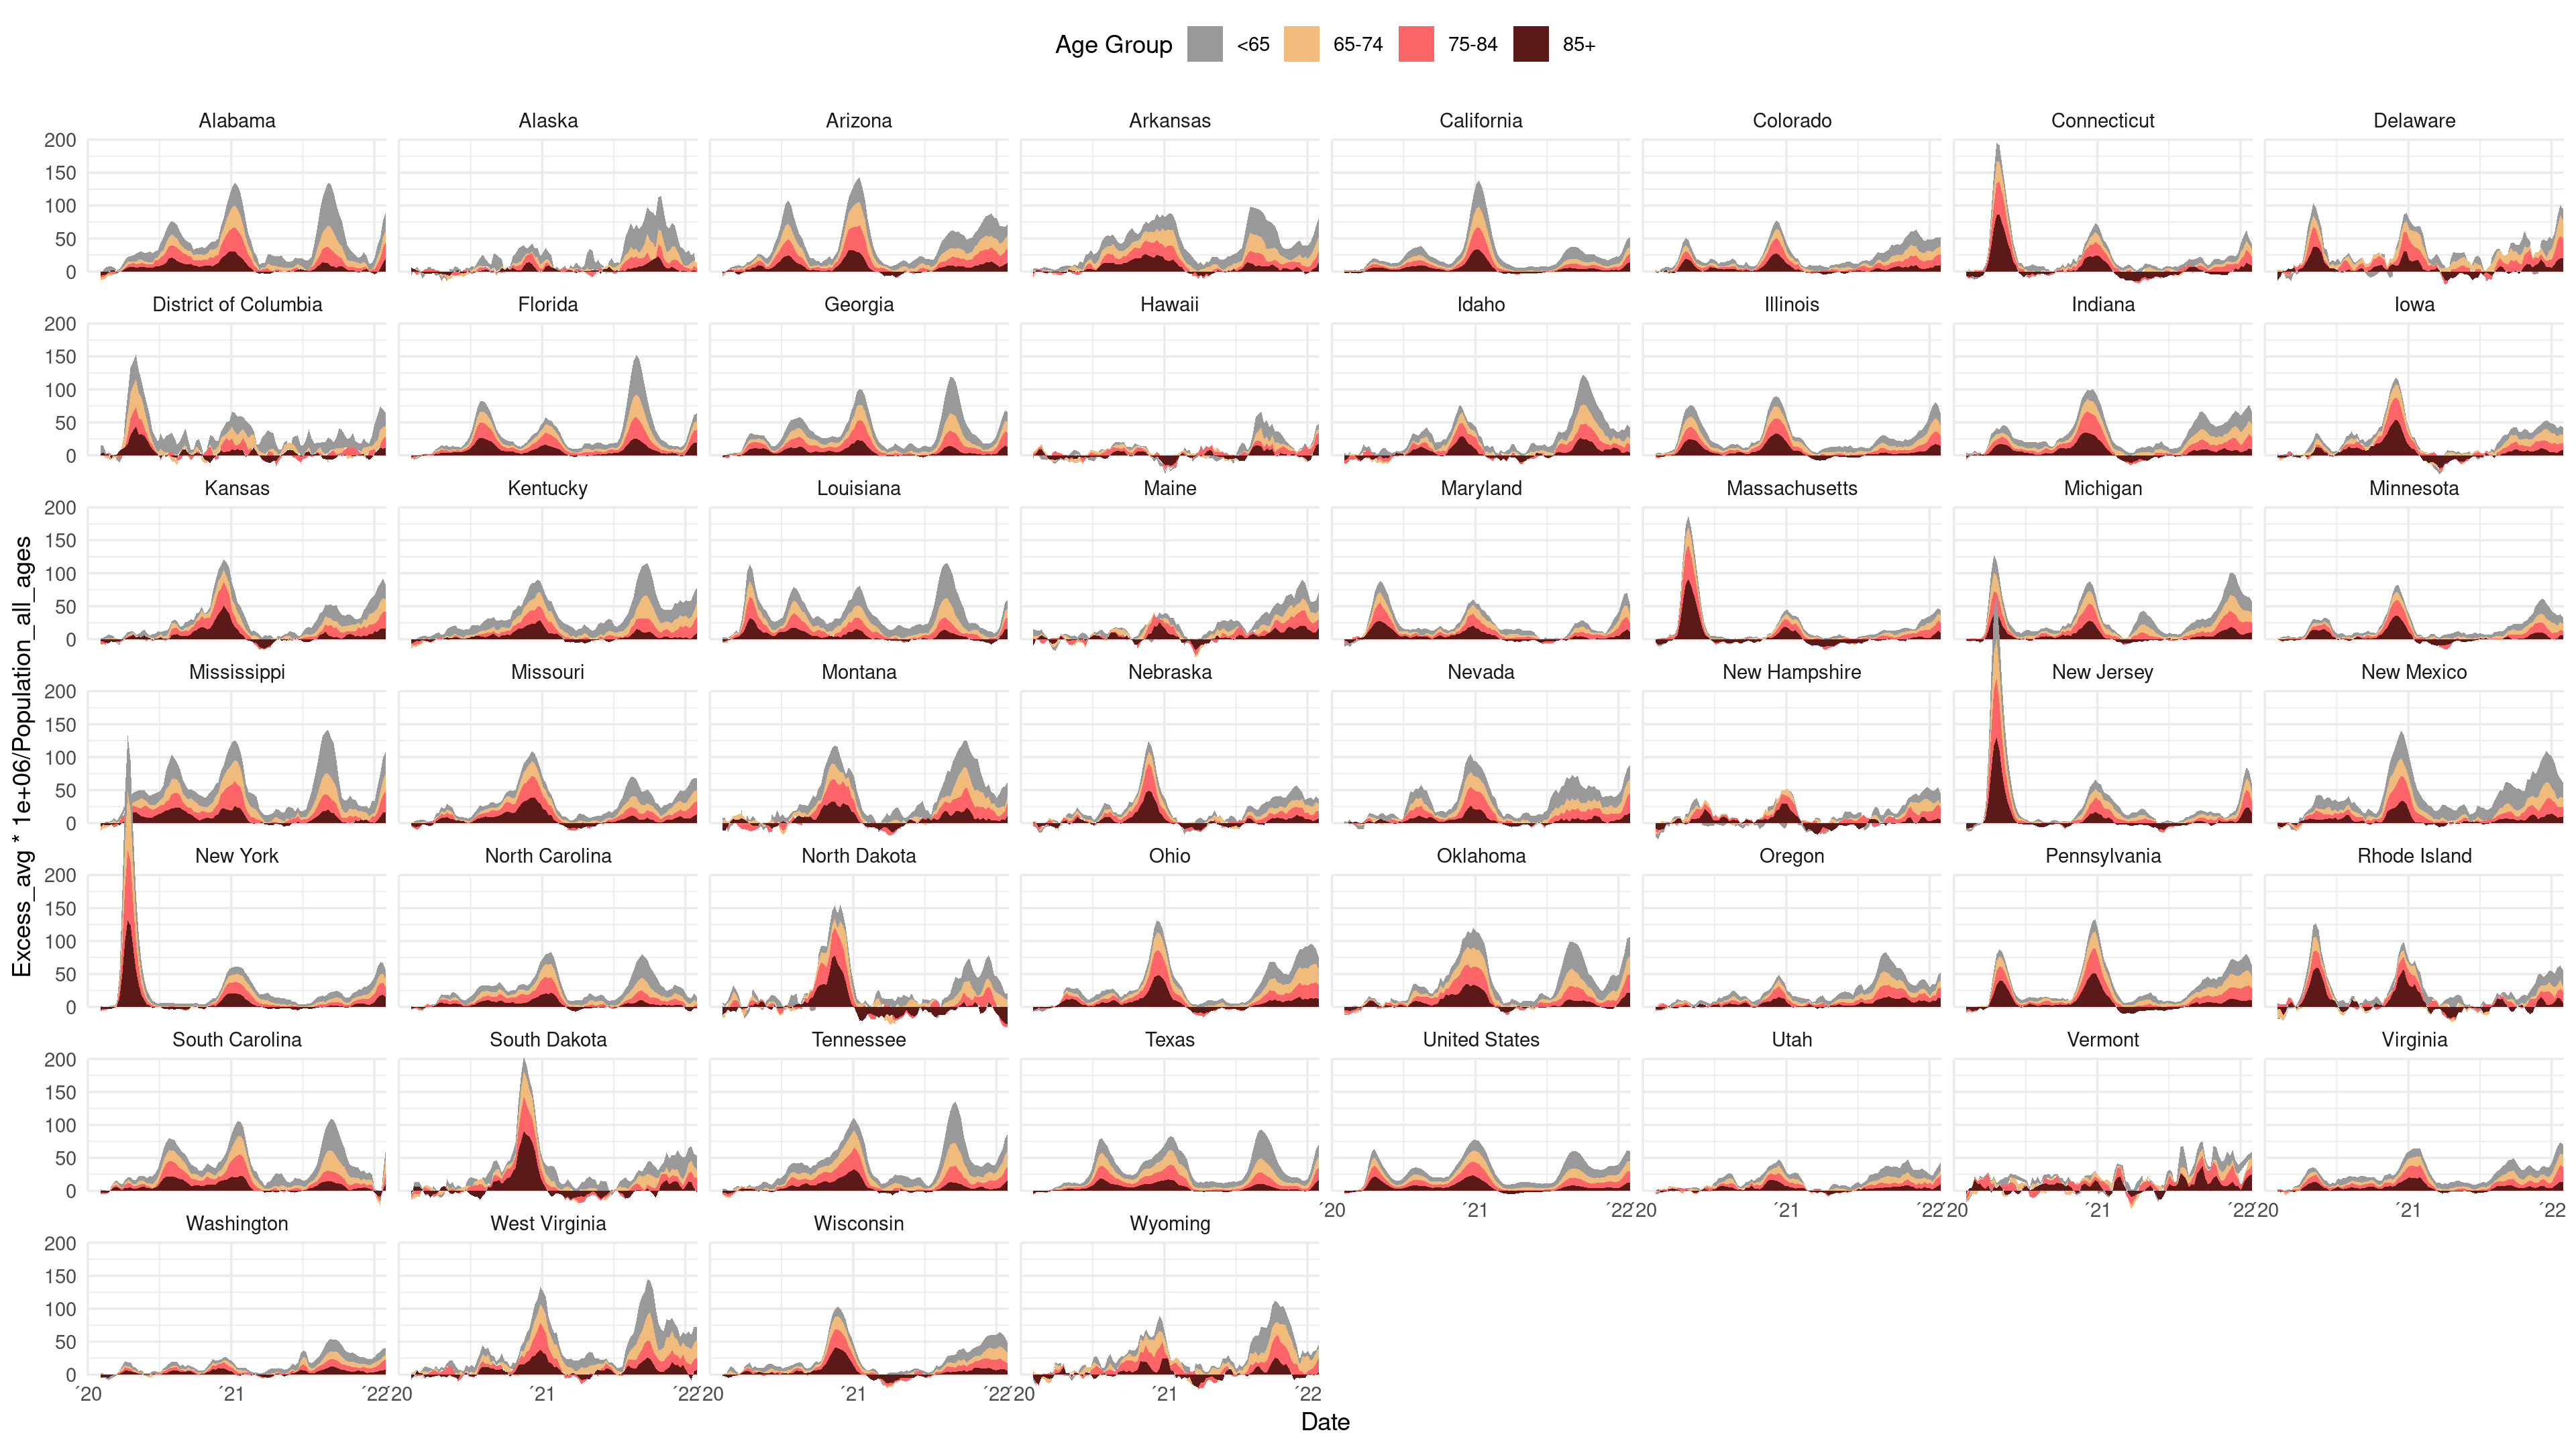

In [7]:
options(repr.plot.width = 16, repr.plot.height = 9, repr.plot.res = 240)

g <- df%>%
  spread(Type, `Number of Deaths`)%>%
  group_by(`Age Group`, Jurisdiction)%>%
  arrange(Date)%>%
  mutate(Excess_avg = zoo::rollmean(Observed-Predicted, k = 3, na.pad = T, align  = "center"))%>%
  filter(Date>="2020-02-01" & Date<"2022-02-01")%>%
  na.omit()%>%
  ggplot(aes(x = Date, y = Excess_avg*1000000/Population_all_ages, fill = `Age Group`)) +
  geom_area() +
  theme(legend.position = "top") +  
  scale_x_date(date_labels = "´%y", date_breaks = "1 year") +
  coord_cartesian(ylim = c(0, 200),
                  xlim = as.Date(c("2020-01-01","2022-02-01")),
                  expand = F,
                  clip = "off") +
  scale_fill_manual(values = c('#999999', '#F1BB7B', '#FD6467', '#5B1A18'))

g + facet_wrap(~Jurisdiction)

Some values in the specified facet_geo column 'Jurisdiction' do not
  match the 'name' column of the specified grid and will be removed:
  United States



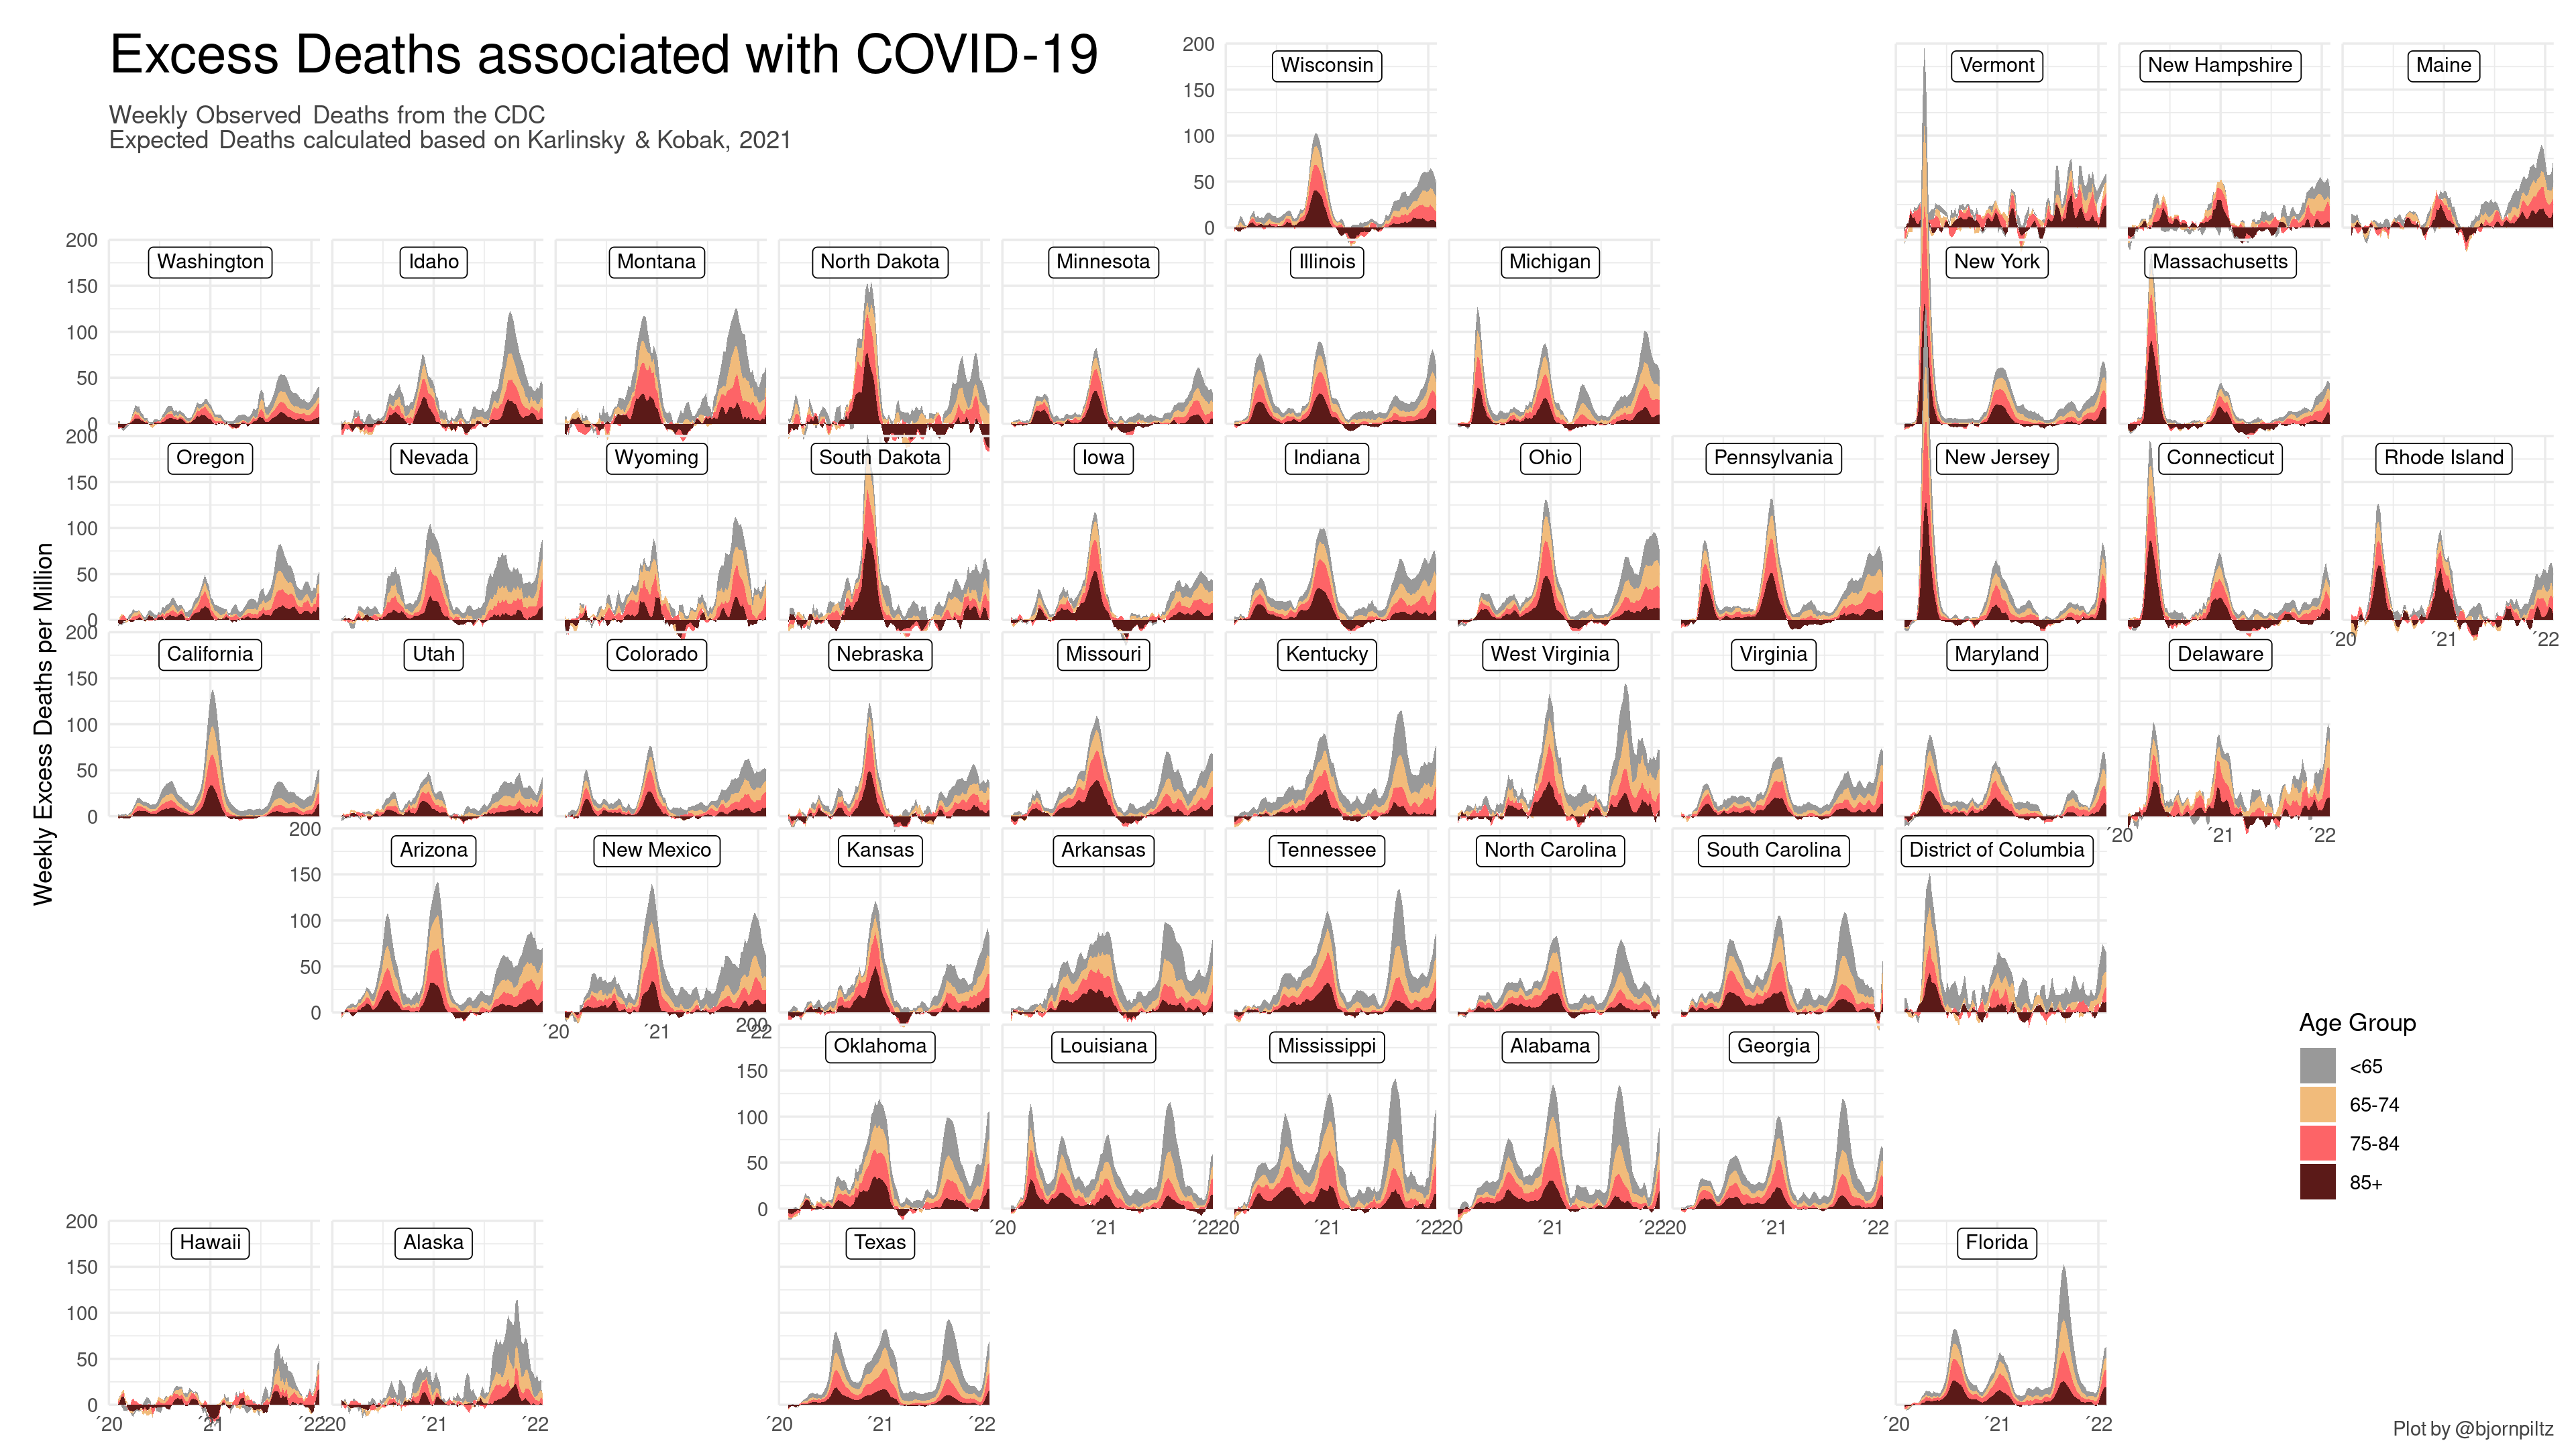

In [9]:
dummy <- 
  df%>%
  group_by(Jurisdiction)%>%
  summarise(Date = as.Date("2021-01-01"))%>%
  filter(!Jurisdiction %in% c("United States", "Puerto Rico"))

g + labs(title = "Excess Deaths associated with COVID-19", 
         subtitle = "<span style='color:#444444;'>Weekly Observed Deaths from the CDC<br>Expected Deaths calculated based on Karlinsky & Kobak, 2021</span>",
         x = "", y = "Weekly Excess Deaths per Million",
         caption = "<span style='color:#444444;'>Plot by @bjornpiltz</span>") +
  geom_label(data = dummy, inherit.aes = FALSE,
             aes(label = Jurisdiction), fill = "white", alpha = 0.7,
             x = as.Date("2021-01-01"), y = 192, size = 3.2, vjust = 1) +
  theme(strip.text.x = element_blank(),
      legend.position = c(0.92, 0.22),
      plot.title=element_text(margin=margin(t=15, b=-40), size = 24),
      plot.subtitle=element_markdown(margin=margin(t=50, b=-50)),
      plot.margin = margin(b=-30, r = 10, l = 15),        
      plot.caption=element_markdown(margin=margin(t=-21, b = -10))) +
  facet_geo(~Jurisdiction)